# Series 4

## Aufgabe 4.1

In [112]:
# 4.1 a) 

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('./data/fitness.csv')

# # As a first inspection, print the first rows of the data:
# print(df.head())
# # As well as the dimensions of the set:
# print('\nSize of fitness =\n', df.shape)    


# Prepare Data
x = df.drop(['oxy'],axis=1) # Predictor Variables
x_sm = sm.add_constant(x)       # Add constant 
y = df['oxy']                   # Response Variable

model = sm.OLS(y, x_sm).fit()   # Fit the model
print(model.summary())          # Print summary 

print('Answer: \n'
      'Yes, there is a association between the predictor variables and the response variable.\n',
      'Significant Predictors: age, runtime, runpulse, maxpulse.\n',)

                            OLS Regression Results                            
Dep. Variable:                    oxy   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     22.43
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           9.72e-09
Time:                        12:00:49   Log-Likelihood:                -66.068
No. Observations:                  31   AIC:                             146.1
Df Residuals:                      24   BIC:                             156.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.9345     12.403      8.299      0.0

In [113]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor

def fit_linear_reg(x, y):
    '''Fit Linear model with predictors x on y 
    return AIC, BIC, R2 and R2 adjusted '''
    x = sm.add_constant(x)
    # Create and fit model
    model_k = sm.OLS(y, x).fit()
    
    # Find scores
    BIC = model_k.bic
    AIC = model_k.aic
    R2 = model_k.rsquared
    R2_adj = model_k.rsquared_adj
    RSS = model_k.ssr
    
    # Return result in Series
    results = pd.Series(data={'BIC': BIC, 'AIC': AIC, 'R2': R2,
                              'R2_adj': R2_adj, 'RSS': RSS})
    
    return results


def add_one(x_full, x, y, scoreby='RSS'):
    ''' Add possible predictors from x_full to x, 
    Fit a linear model on y using fit_linear_reg
    Returns Dataframe showing scores as well as best model '''
    # Predefine DataFrame
    x_labels = x_full.columns
    zeros = np.zeros(len(x_labels))
    results = pd.DataFrame(
        data={'Predictor': x_labels.values, 'BIC': zeros, 
               'AIC': zeros, 'R2': zeros, 
               'R2_adj': zeros, 'RSS': zeros})

    # For every predictor find R^2, RSS, and AIC
    for i in range(len(x_labels)):
        x_i = np.concatenate((x, [np.array(x_full[x_labels[i]])]))
        results.iloc[i, 1:] = fit_linear_reg(x_i.T, y)
        
    # Depending on where we scoreby, we select the highest or lowest
    if scoreby in ['RSS', 'AIC', 'BIC']:
        best = x_labels[results[scoreby].argmin()]
    elif scoreby in ['R2', 'R2_adj']:
        best = x_labels[results[scoreby].argmax()]
        
    return results, best 

def drop_one(x, y, scoreby='RSS'):
    ''' Remove possible predictors from x, 
    Fit a linear model on y using fit_linear_reg
    Returns Dataframe showing scores as well as predictor 
    to drop in order to keep the best model '''
    # Predefine DataFrame
    x_labels = x.columns
    zeros = np.zeros(len(x_labels))
    results = pd.DataFrame(
        data={'Predictor': x_labels.values, 'BIC': zeros, 
               'AIC': zeros, 'R2': zeros, 
               'R2_adj': zeros, 'RSS': zeros})

    # For every predictor find RSS and R^2
    for i in range(len(x_labels)):
        x_i = x.drop(columns=x_labels[i])
        results.iloc[i, 1:] = fit_linear_reg(x_i, y)
    
    # Depending on where we scoreby, we select the highest or lowest
    if scoreby in ['RSS', 'AIC', 'BIC']:
        worst = x_labels[results[scoreby].argmin()]
    elif scoreby in ['R2', 'R2_adj']:
        worst = x_labels[results[scoreby].argmax()]
    
    return results, worst 


""" Plot Residuals vs Fitted Values """
def plot_residuals(axes, res, yfit, n_samp=0):
    """ Inputs:
    axes: axes created with matplotlib.pyplot
    x: x values
    ytrue: y values
    yfit: fitted/predicted y values
    res[optional]: Residuals, used for resampling
    n_samp[optional]: number of resamples """
    # For every random resampling
    for i in range(n_samp):
        # 1. resample indices from Residuals
        samp_res_id = random.sample(list(res), len(res))
        # 2. Average of Residuals, smoothed using LOWESS
        sns.regplot(x=yfit, y=samp_res_id,
        scatter=False, ci=False, lowess=True,
        line_kws={'color': 'lightgrey', 'lw': 1, 'alpha': 0.8})
        # 3. Repeat again for n_samples

    dataframe = pd.concat([yfit, res], axis=1)
    axes = sns.residplot(x=yfit, y=res, data=dataframe, 
                         lowess=True, scatter_kws={'alpha': 0.5}, 
                         line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axes.set_title('Residuals vs Fitted')
    axes.set_ylabel('Residuals')
    axes.set_xlabel('Fitted Values')
    
""" QQ Plot standardized residuals """
def plot_QQ(axes, res_standard, n_samp=0):
    """ Inputs:
    axes: axes created with matplotlib.pyplot
    res_standard: standardized residuals
    n_samp[optional]: number of resamples """
    
    # QQ plot instance
    QQ = ProbPlot(res_standard)
    # Split the QQ instance in the seperate data
    qqx = pd.Series(sorted(QQ.theoretical_quantiles), name="x")
    qqy = pd.Series(QQ.sorted_data, name="y")
    if n_samp != 0:
        # Estimate the mean and standard deviation
        mu = np.mean(qqy)
        sigma = np.std(qqy)
        # For ever random resampling
        for lp in range(n_samp):
            # Resample indices
            samp_res_id = np.random.normal(mu, sigma, len(qqx))
            # Plot
            sns.regplot(x=qqx, y=sorted(samp_res_id),
            scatter=False, ci=False, lowess=True,
            line_kws={'color': 'lightgrey', 'lw': 1, 'alpha': 0.8})

            sns.regplot(x=qqx, y=qqy, scatter=True, lowess=False, 
                        ci=False, scatter_kws={'s': 40, 'alpha': 0.5}, 
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
            
    axes.plot(qqx, qqx, '--k', alpha=0.5)
    axes.set_title('Normal Q-Q')
    axes.set_xlabel('Theoretical Quantiles')
    axes.set_ylabel('Standardized Residuals')

""" Scale-Location Plot """
def plot_scale_loc(axes, yfit, res_stand_sqrt, n_samp=0):
    """ Inputs:
    axes: axes created with matplotlib.pyplot
    yfit: fitted/predicted y values
    res_stand_sqrt: Absolute square root Residuals
    n_samp[optional]: number of resamples """
    
    # For every random resampling
    for i in range(n_samp):
    # 1. resample indices from sqrt Residuals
        samp_res_id = random.sample(list(res_stand_sqrt), len(res_stand_sqrt))
        # 2. Average of Residuals, smoothed using LOWESS
        sns.regplot(x=yfit, y=samp_res_id,
                    scatter=False, ci=False, lowess=True,
                    line_kws={'color': 'lightgrey', 'lw': 1, 'alpha': 0.8})
        # 3. Repeat again for n_samples

    # plot Regression usung Seaborn
    sns.regplot(x=yfit, y=res_stand_sqrt,
                scatter=True, ci=False, lowess=True,
                scatter_kws={'s': 40, 'alpha': 0.5},
                
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axes.set_title('Scale-Location plot')
    axes.set_xlabel('Fitted values')
    axes.set_ylabel('$\sqrt{\|Standardized\ Residuals\|}$')

def plot_cooks(axes, res_inf_leverage, res_standard, n_pred=1,
               x_lim=None, y_lim=None, n_levels=4):
    """ Inputs:
    axes: axes created with matplotlib.pyplot
    res_inf_leverage: Leverage
    res_standard: standardized residuals
    n_pred: number of predictor variables in x
    x_lim, y_lim[optional]: axis limits
    n_levels: number of levels"""
    
    sns.regplot(x=res_inf_leverage, y=res_standard,
                scatter=True, ci=False, lowess=True,
                scatter_kws={'s': 40, 'alpha': 0.5},
                
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    # Set limits
    if x_lim != None:
        x_min, x_max = x_lim[0], x_lim[1]
    else:
        x_min, x_max = min(res_inf_leverage)*0.95, max(res_inf_leverage)*1.05
    if y_lim != None:
        y_min, y_max = y_lim[0], y_lim[1]
    else:
        y_min, y_max = min(res_standard)*0.95, max(res_standard)*1.05

    # Plot centre line
    plt.plot((x_min, x_max), (0, 0), 'g--', alpha=0.8)
    # Plot contour lines for Cook's Distance levels
    n = 100
    cooks_distance = np.zeros((n, n))
    x_cooks = np.linspace(x_min, x_max, n)
    y_cooks = np.linspace(y_min, y_max, n)

    for xi in range(n):
        for yi in range(n):
            cooks_distance[yi][xi] = \
            y_cooks[yi]**2 * x_cooks[xi] / (1 - x_cooks[xi]) / (n_pred + 1)
            
    CS = axes.contour(x_cooks, y_cooks, cooks_distance, levels=n_levels, alpha=0.6)

    axes.clabel(CS, inline=0, fontsize=10)
    axes.set_xlim(x_min, x_max)
    axes.set_ylim(y_min, y_max)
    axes.set_title('Residuals vs Leverage and Cook\'s distance')
    axes.set_xlabel('Leverage')
    axes.set_ylabel('Standardized Residuals')
    
""" Standard scatter plot and regression line """
def plot_reg(axes, x, y, x_lab="x", y_lab="y", title="Linear Regression"):
    """ Inputs:
    axes: axes created with matplotlib.pyplot
    x: (single) Feature
    y: Result """
    # Plot scatter data
    sns.regplot(x=x, y=y,
                scatter=True, ci=False, lowess=False,
                scatter_kws={'s': 40, 'alpha': 0.5},
                
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    # Set labels:
    axes.set_xlabel(x_lab)
    axes.set_ylabel(y_lab)
    axes.set_title(title)

""" VIF Analysis """
def VIF_analysis(x):
    """ VIF analysis of variables saved in x
    Input:
    x: m*n matrix or Dataframe, containing m samples of n predictors
    Output:
    VIF: Vector containing n Variance Inflation Factors
    """
    # Preproces:
    x_np = x.to_numpy()
    VIF = []
    # For all n Predictors:
    for i in range(x.shape[1]):
        # Define x and y
        x_i = np.delete(x_np, i, 1)
        x_i = sm.add_constant(x_i)
        y_i = x_np[:, i]
        # Fit model
        model = sm.OLS(y_i, x_i).fit()
        # Calculate the VIF
        VIF.append(1 / (1 - model.rsquared))
    
    return VIF

def plot_resid_analysis(model):
    # Find the predicted values for the original design.
    yfit = model.fittedvalues
    # Find the Residuals
    res = model.resid
    # Influence of the Residuals
    res_inf = model.get_influence()
    # Studentized residuals using variance from OLS
    res_standard = res_inf.resid_studentized_internal
    # Absolute square root Residuals:
    res_stand_sqrt = np.sqrt(np.abs(res_standard))
    # Cook's Distance and leverage:
    res_inf_cooks = res_inf.cooks_distance
    res_inf_leverage = res_inf.hat_matrix_diag

    """ Plots """
    # Create Figure and subplots
    fig = plt.figure(figsize = (12,9))

    # First subplot: Residuals vs Fitted values with 100 resamples
    ax1 = fig.add_subplot(2, 2, 1)
    plot_residuals(ax1, res, yfit, n_samp = 100)

    # Second subplot: QQ Plot with 100 resamples
    ax2 = fig.add_subplot(2, 2, 2)
    plot_QQ(ax2, res_standard, n_samp = 100)

    # Third subplot: Scale-location with 100 resamples
    ax3 = fig.add_subplot(2, 2, 3)
    plot_scale_loc(ax3, yfit, res_stand_sqrt, n_samp = 100)

    # Fourth subplot: Residuals vs Fitted values with 100 resamples
    ax4 = fig.add_subplot(2, 2, 4)
    plot_cooks(ax4, res_inf_leverage, res_standard, n_pred = model.df_model)

    return


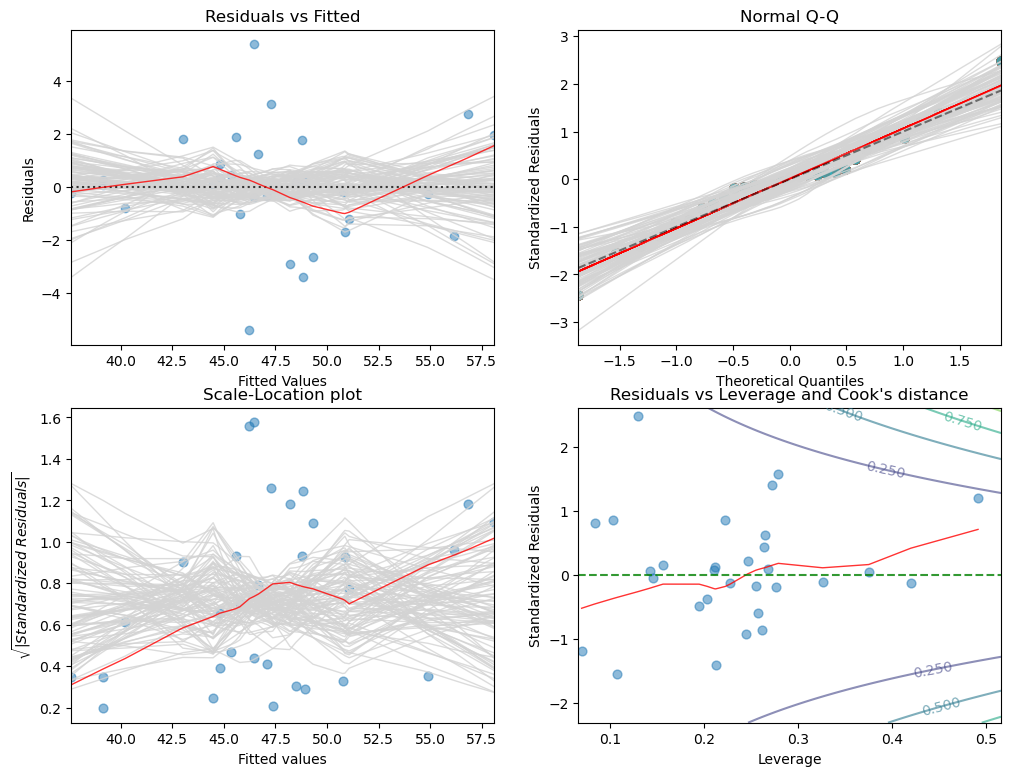

In [114]:
# 4.1 b) 

plot_resid_analysis(model)

In [115]:
# 4.1 c) Korrelation? 
print(round(df.drop(['oxy'],axis=1).corr(), 4))
print('\nFazit: Hohe Korrelation zwischen den Variablen runpulse und maxpulse \n')

             age  weight  runtime  rstpulse  runpulse  maxpulse
age       1.0000 -0.2335   0.1887   -0.1641   -0.3379   -0.4329
weight   -0.2335  1.0000   0.1435    0.0440    0.1815    0.2494
runtime   0.1887  0.1435   1.0000    0.4504    0.3136    0.2261
rstpulse -0.1641  0.0440   0.4504    1.0000    0.3525    0.3051
runpulse -0.3379  0.1815   0.3136    0.3525    1.0000    0.9298
maxpulse -0.4329  0.2494   0.2261    0.3051    0.9298    1.0000

Fazit: Hohe Korrelation zwischen den Variablen runpulse und maxpulse 



In [116]:
# 4.1 d) Korrelation durch VIF 
VIF = VIF_analysis(x)

res = pd.DataFrame(data={'Predictor': x.columns,
                         'VIF': np.round(VIF, 3)})
print(res.T)

               0       1        2         3         4         5
Predictor    age  weight  runtime  rstpulse  runpulse  maxpulse
VIF        1.513   1.155    1.591     1.416     8.437     8.744


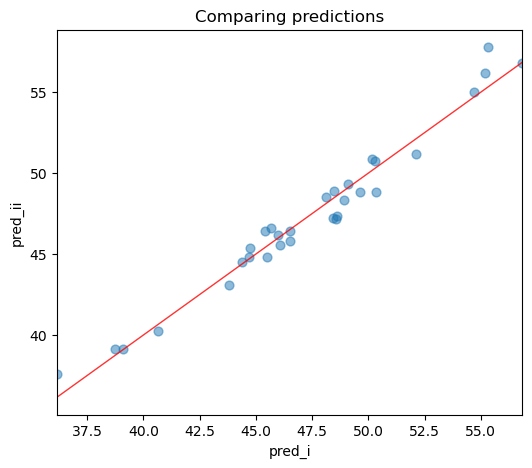

In [117]:
# 4.1 e) Fix der Multikollinearität
# i) Weglassen 
x_i = df.drop(['oxy','maxpulse'], axis=1)
x_i_sm = sm.add_constant(x_i)  # Add constant
model_i = sm.OLS(y, x_i_sm).fit()

x_ii = df.drop(['oxy', 'maxpulse'], axis=1)
newvar = df['runpulse'] / df['maxpulse']
newvar = newvar.rename('run/max')
x_ii = x_ii.join(newvar)

x_ii_sm = sm.add_constant(x_ii)  # Add constant
model_ii = sm.OLS(y, x_ii_sm).fit()

# paarweise vergleich: 
pred_i = model_i.predict(sm.add_constant(x_i))
pred_ii = model_ii.predict(sm.add_constant(x_ii))

fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(1, 1, 1)

plot_reg(ax1, pred_i, pred_ii,
         x_lab="pred_i", y_lab="pred_ii",
         title="Comparing predictions")
plt.show()

In [118]:
# 4.1 f) Forward Stepwise Model Selection
x_red = x.copy() # Copy the full set of predictors

x_copy = x.copy() 
x_forward = [np.zeros(len(y))]

results = pd.DataFrame(data={'Best_Pred': [], 'AIC':[]}) # Define the empty predictor

for i in range(x_red.shape[1]):
    results_i, best_i = add_one(x_red, x_forward, y, scoreby='AIC')

    # Update the empty predictor with the best predictor
    x_forward = np.concatenate((x_forward, [x_copy[best_i]]))

    # Remove the chosen predictor from the list of options
    x_red = x_red.drop(columns=best_i)

    # Save results
    results.loc[i, 'Best_Pred'] = best_i
    results.loc[i, 'AIC'] = results_i['AIC'].min()
    results.loc[i, 'R2'] = results_i['R2'].min()
    results.loc[i, 'RSS'] = results_i['RSS'].min()

print('Best Predictors and corresponding AIC:\n', results,
'\n\nThe best model thus contains',
results['AIC'].argmin() + 1, ' predictors') # change this to needed metric

Best Predictors and corresponding AIC:
   Best_Pred         AIC        R2         RSS
0   runtime  152.508320  0.026488  218.481445
1       age  151.879177  0.743533  200.715812
2  runpulse  147.011504  0.767349  160.830689
3  maxpulse  144.473666  0.811670  138.930018
4    weight  144.272770  0.837031  129.408451
5  rstpulse  146.135801  0.848672  128.837938 

The best model thus contains 5  predictors


In [119]:
# 4.1 f) anova test
x_opt = x_ii[['runtime', 'run/max', 'age', 'weight']]
x_opt_sm = sm.add_constant(x_opt)  # Add constant
model_opt = sm.OLS(y, x_opt_sm).fit()  # Fit the model

# Anova Test:
table = sm.stats.anova_lm(model, model_opt)
print('\nANOVA Test:\n', table)


ANOVA Test:
    df_resid         ssr  df_diff   ss_diff         F  Pr(>F)
0      24.0  128.837938      0.0       NaN       NaN     NaN
1      26.0  138.184286     -2.0 -9.346349  0.879279     NaN


## Aufgabe 4.2

In [120]:
df = pd.read_csv('./data/senic.csv')
df.head()

# transform Dummy Variables
df = pd.get_dummies(df, columns=['region'])
x = df.drop(['length','id', "cult","school", "serv"], axis=1)  # Predictor Variables
y = df['length']  # Response Variable

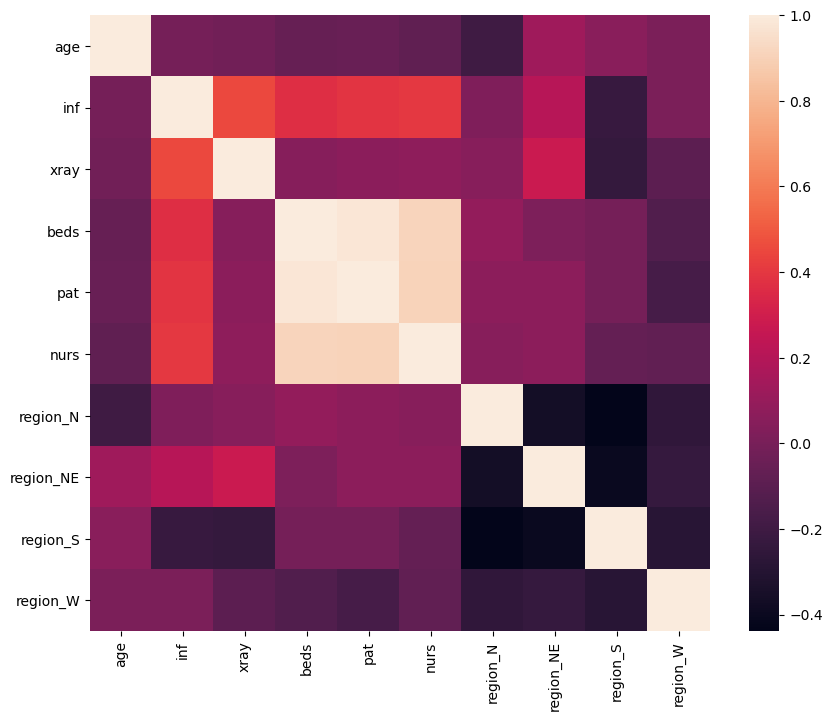

In [121]:
# 4.2 a) Correlation
corr = round(x.corr(), 4)
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(corr)
plt.show()

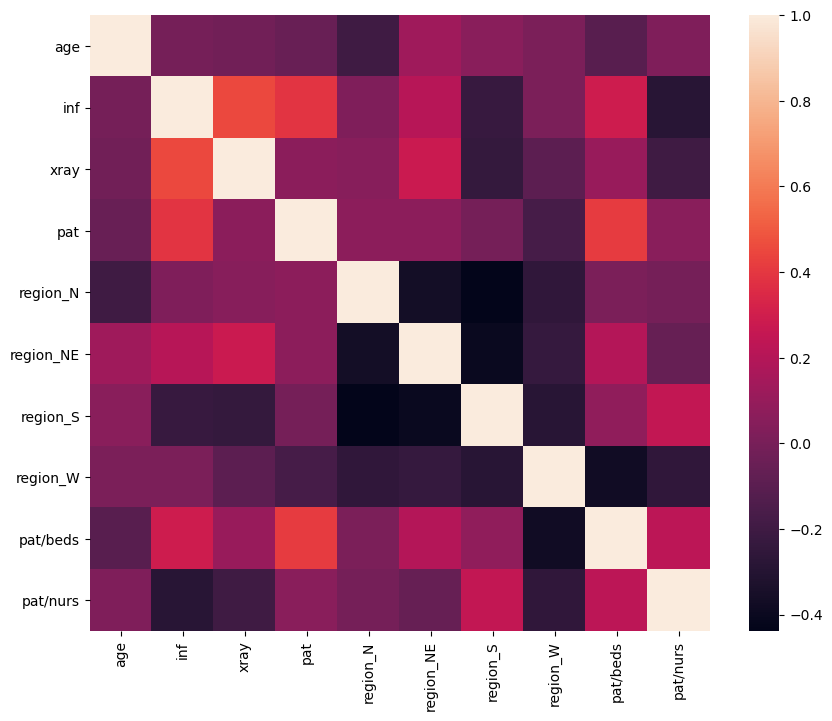

In [122]:
# 4.2 b) Replace variables 
pat_beds = x['pat'] / x['beds']
pat_beds = pat_beds.rename('pat/beds')
pat_nurs = x['pat'] / x['nurs']
pat_nurs = pat_nurs.rename('pat/nurs')

x_i = x.copy()
x_i = x_i.drop(columns=['beds', 'nurs'], axis=1)
x_i = x_i.join(pat_beds)
x_i = x_i.join(pat_nurs)

# check correlation again
fig.clear()
corr = round(x_i.corr(), 4)
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(corr)
plt.show()

In [123]:
# 4.2 d) Log transform

x_ii = x_i.copy()
x_ii[['pat', 'pat/nurs']] = np.log(x_ii[['pat','pat/nurs']])
x_ii.rename(columns={'pat': 'log(pat)', 'pat/nurs': 'log(pat/nurs)'},
          inplace=True)
y = np.log(y)

# Fit Model
x_ii_sm = sm.add_constant(x_ii)  # Add constant
model_ii = sm.OLS(y, x_ii_sm).fit()
print(model_ii.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     18.86
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           3.23e-18
Time:                        12:00:53   Log-Likelihood:                 90.231
No. Observations:                 113   AIC:                            -160.5
Df Residuals:                     103   BIC:                            -133.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9393      0.143      6.575

In [ ]:
# 4.2 e) backward stepwise selection

# Define the full predictor
x_back = x_ii.copy()

# ---------------------------- 

x_copy = x_back.copy() 
results = pd.DataFrame(data={'Worst_Pred': [], 'BIC':[]}) 
shape = x_back.shape[1]

for i in range(x_back.shape[1]):
    results_i, worst_i = drop_one(x_back, y, scoreby='BIC')

    # Update the empty predictor with the best predictor
    x_back = x_back.drop(columns=worst_i)

    # Save results
    results.loc[i, 'Worst_Pred'] = worst_i
    results.loc[i, 'BIC'] = results_i['BIC'].min()

print('Worst Predictors and corresponding BIC:\n', results,
    '\n\nThe best model thus contains',
    shape - results['BIC'].argmin(), ' predictors')


# fit model 
x_bwd = x_copy[results.iloc[:8, 0]]
x_bwd_sm = sm.add_constant(x_bwd)

# Fit the linear model
model_bwd = sm.OLS(y, x_bwd_sm).fit()

Worst Predictors and corresponding BIC:
       Worst_Pred         BIC
0       pat/beds -137.132551
1           xray -137.670667
2       region_N -137.670667
3       region_S -139.743552
4  log(pat/nurs) -139.911888
5            age -136.551672
6       log(pat) -131.179926
7      region_NE -123.963321
8       region_W -102.130871
9            inf  -65.703326 

The best model thus contains 6  predictors


In [125]:
# 4.2 f) Forward stepwise selection 

x_red = x_ii.copy() # Copy the full set of predictors

# ---------------------------- 

x_copy = x_red.copy() 
x_forward = [np.zeros(len(y))]
results = pd.DataFrame(data={'Best_Pred': [], 'AIC':[]}) # Define the empty predictor

for i in range(x_red.shape[1]):
    results_i, best_i = add_one(x_red, x_forward, y, scoreby='AIC')

    # Update the empty predictor with the best predictor
    x_forward = np.concatenate((x_forward, [x_copy[best_i]]))

    # Remove the chosen predictor from the list of options
    x_red = x_red.drop(columns=best_i)

    # Save results
    results.loc[i, 'Best_Pred'] = best_i
    results.loc[i, 'AIC'] = results_i['AIC'].min()
    results.loc[i, 'R2'] = results_i['R2'].min()
    results.loc[i, 'RSS'] = results_i['RSS'].min()

print('Best Predictors and corresponding AIC:\n', results,
'\n\nThe best model thus contains',
results['AIC'].argmin() + 1, ' predictors') # change this to needed metric

# fit model 
x_fwd = x_copy[results.iloc[:8, 0]]
x_fwd_sm = sm.add_constant(x_fwd)

# Fit the linear model
model_fwd = sm.OLS(y, x_fwd_sm).fit()

Best Predictors and corresponding AIC:
        Best_Pred         AIC        R2       RSS
0            inf -107.585646  0.002049  2.464594
1       region_W -132.145485  0.306249  1.948353
2      region_NE -142.089477  0.455423  1.752924
3       log(pat) -150.188612  0.507994  1.603057
4            age -156.276215  0.550693  1.492333
5  log(pat/nurs) -158.835267  0.585366  1.433322
6           xray -161.587553  0.597993  1.374293
7       region_S -161.679041  0.614594  1.349091
8       region_N -161.679041  0.619702  1.339781
9       pat/beds -160.461513  0.622326  1.339781 

The best model thus contains 8  predictors


In [126]:
# 4.2 g) 
# skipped

In [128]:
# 4.2 h) Anova Test
table = sm.stats.anova_lm(model_ii, model_bwd, model_fwd)
print(table)

   df_resid       ssr  df_diff   ss_diff          F  Pr(>F)
0     103.0  1.339781      0.0       NaN        NaN     NaN
1     104.0  1.551789     -1.0 -0.212008  16.343475     NaN
2     104.0  1.349091     -0.0  0.202698       -inf     NaN
